# Metabolomics data preparations

## 1. Removal of technical variations

Here we used an output file from TableExporter with header-style "FIELD-NAME". Tutorial: https://cran.r-project.org/web/packages/ukbnmr/vignettes/ukbnmr.html#:~:text=library(ukbnmr)%20library(data,sample_qc_flags%20%3C%2D%20extract_sample_qc_flags(exported)

In [ ]:
%%bash
dx download "exported_121225.csv" "ukbnmr_removing_technical_variation_v2.r"

In [ ]:
# Running the technical variation removal using ukbnmr package in R
import subprocess
subprocess.run(["Rscript", "ukbnmr_removing_technical_variation_v2.r", "exported_121225.csv"])

CompletedProcess(args=['Rscript', 'ukbnmr_removing_technical_variation_v2.r', 'exported_121225.csv'], returncode=0)

In [ ]:
%%bash
dx upload *.csv

ID                                file-J501zv0JZ8jx7JpGfPVff7qJ
Class                             file
Project                           project-J0yb91QJZ8jZ9ppFk6zGQgGp
Folder                            /
Name                              exported_121225.csv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Mon Dec 15 14:49:20 2025
Created by                        agarham
 via the job                      job-J5011Q8JZ8jj9bYp0Xkx7XgB
Last modified                     Mon Dec 15 14:49:24 2025
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"
ID                                file-J501zx0JZ8jp6P7fY70Z1yy0
Class                             file
Project                           project-J0yb91QJZ8

## 2. Handling Missingness

Prior to this step, we performed correction on technical variation using the ukbnmr R package: https://cran.r-project.org/web/packages/ukbnmr/vignettes/ukbnmr.html. The final output of this process will be imputed using QRILC method in R.

### 2.1. Preparation and initial checking

In [ ]:
# Install scikit-learn
!pip install scikit-learn missingno

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 153.1 MB/s eta 0:00:00


In [ ]:
%%bash
dx download "exported_121225.tsv" "UKB Metabolomics:/agarham/biomarker_bridge.csv"

In [ ]:
import pandas as pd
import numpy as np

# Load the original metabolomics dataset (containing variables other than metabolites too)
biomarker_orig = pd.read_csv('exported_121225.tsv', sep = '\t', low_memory=False)

# Import data containing the data fields, metabolite name, abbreviations (to be used as column names), and categories of the metabolites
met_info = pd.read_csv('biomarker_bridge.csv', sep = ';')

# Create a list of metabolite columns to be selected from the dataframe, only containing the initial visit data
met_cols = [f'{met}-0.0' for met in met_info['ukb_field']] # This turns all the data fields into the initial visit format, e.g. '23475' into 'f.23475.0.0'

# Create a list of column names from the abbreviations
met_names = met_info['biomarker_hunt']

# Create a dictionary to pair the old column names with the new column names
met_cols_map = dict(zip(met_cols, met_names))

# Select and rename the columns
biomarker_orig = biomarker_orig[['eid'] + met_cols]
biomarker_orig = biomarker_orig.rename(columns=met_cols_map)

In [ ]:
# Load the ukbnmr output datasets
biomarker = pd.read_csv('nmr_biomarker_data_nonderived.csv')
biomarker_qc = pd.read_csv('nmr_biomarker_qc_flags_nonderived.csv', low_memory=False) # Containig the corrected non-derived biomarker only
sample_qc = pd.read_csv('nmr_sample_qc_flags_full.csv') # Containig the corrected non-derived biomarker only

# Check the datasets
print('biomarker_orig shape:')
print(biomarker_orig.shape) # the latest release per 12/12/25: 501936 (some participants withdrawed)

print('biomarker shape:')
print(biomarker.shape)

print('biomarker qc shape:')
print(biomarker_qc.shape)

print('sample qc shape:')
print(sample_qc.shape)

print('eid in the original covers all eids in corrected biomarker df?')
print(biomarker['eid'].isin(biomarker_orig['eid']).all())

print('same set and order of eid in the corrected vs qc df?')
print(biomarker['eid'].tolist() == biomarker_qc['eid'].tolist())

biomarker_orig shape:
(501936, 250)
biomarker shape:
(488088, 110)
biomarker qc shape:
(488088, 110)
sample qc shape:
(488092, 22)
eid in the original covers all eids in corrected biomarker df?
True
same set and order of eid in the corrected vs qc df?
True


The actual number of participants with metabolomics data available (reported from Nightingale) is 491000 for baseline samples. Lower number from the ukbnmr output is likely from the outlier plates removal step (step 8: "Samples belonging to shipment plates that are outliers of non-biological origin are identified and set to missing"). For imputation, we will only use the non-derived biomarkers, and recompute the derived biomarkers after imputation finished.

Before performing pre-processing, we check the output of ukbnmr (corrected for technical variation) vs the original metabolomics dataset.

In [ ]:
# Check the range of the original metabolomics dataset
ranges_orig = pd.DataFrame({
    'min': biomarker_orig.min(),
    'max': biomarker_orig.max()
})

ranges_orig.index.name = 'metabolite'
ranges_orig.reset_index(inplace=True)

ranges_sorted_orig = ranges_orig.sort_values(by='max', ascending=False).sort_index()

# Check the range of the corrected metabolomics dataset
ranges = pd.DataFrame({
    'min': biomarker.min(),
    'max': biomarker.max()
})

ranges.index.name = 'metabolite'
ranges.reset_index(inplace=True)

ranges_sorted = ranges.sort_values(by='max', ascending=False).sort_index()

# Compare the two
orig_vs_corr = pd.merge(ranges_sorted_orig, ranges_sorted, on='metabolite', suffixes=('_orig', '_corr'))
orig_vs_corr['min_shift'] = orig_vs_corr['min_corr'] - orig_vs_corr['min_orig']
orig_vs_corr['max_shift'] = orig_vs_corr['max_corr'] - orig_vs_corr['max_orig']

orig_vs_corr.to_csv('range_original_vs_corrected_metabolites_nonderived.csv', index = False)

In [ ]:
%%bash
dx upload "range_original_vs_corrected_metabolites_nonderived.csv"

ID                                file-J50232QJZ8jq161f8F1gZvXy
Class                             file
Project                           project-J0yb91QJZ8jZ9ppFk6zGQgGp
Folder                            /
Name                              range_original_vs_corrected_metabolites_nonderived.csv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Mon Dec 15 14:56:10 2025
Created by                        agarham
 via the job                      job-J5011Q8JZ8jj9bYp0Xkx7XgB
Last modified                     Mon Dec 15 14:56:11 2025
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"


In [ ]:
# Visualize the comparison between the original and corrected metabolites
import matplotlib.pyplot as plt
import os

# Constants
N_COLS_PER_PAGE = 4  # Number of plots horizontal
N_ROWS_PER_PAGE = 3  # Number of plots vertical
PLOTS_PER_PAGE = N_COLS_PER_PAGE * N_ROWS_PER_PAGE

# Remove eid column (first column)
df1_data = biomarker_orig.iloc[:, 1:]
df2_data = biomarker.iloc[:, 1:]

# Get shared columns (in case of mismatch)
columns = df1_data.columns.intersection(df2_data.columns)

# Output directory
output_dir = "ukbnmr_checks"
os.makedirs(output_dir, exist_ok=True)

page_num = 1

for i in range(0, len(columns), PLOTS_PER_PAGE):
    cols_batch = columns[i:i + PLOTS_PER_PAGE]

    fig, axes = plt.subplots(
        N_ROWS_PER_PAGE,
        N_COLS_PER_PAGE,
        figsize=(8.27, 11.69)  # A4 size in inches
    )
    axes = axes.flatten()

    for j, col in enumerate(cols_batch):
        ax = axes[j]
        ax.boxplot(
            [df1_data[col].dropna(), df2_data[col].dropna()],
            tick_labels=['orig', 'corr'],
            patch_artist=True
        )
        ax.set_title(col, fontsize=8)

    # Hide unused axes
    for j in range(len(cols_batch), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()

    # Save JPG
    output_path = os.path.join(
        output_dir, f"boxplot_original_vs_corrected_page_{page_num}.jpg"
    )
    plt.savefig(output_path, dpi=300, format="jpg")
    plt.close(fig)

    page_num += 1


In [ ]:
%%bash
dx upload -r ukbnmr_checks

### 2.2. Remove samples with potential dilution and missing values >10%

In [ ]:
# Check the sample qc flag with potential dilution: Low Protein

print('Number of low protein flags:')
print(sample_qc['Low.Protein'].value_counts())

Number of low protein flags:
Low.Protein
Yes    2518
Name: count, dtype: int64


In [ ]:
# Find rows with >10% NaN or 0 (excluding first column: 'eid')
biomarker_only = biomarker.iloc[:, 1:]
num_columns = biomarker_only.shape[1]
threshold = int(num_columns * 0.1)

mask = biomarker_only.isna() | (biomarker_only == 0)
rows_manynanzero = mask.sum(axis=1) > threshold
eids_manynanzero = biomarker.loc[rows_manynanzero, 'eid']

# Get the low protein flagged eids from the sample qc flag dataset
eids_lowprot = sample_qc.loc[sample_qc['Low.Protein'] == 'Yes', 'eid']

# Combine both sets of eids to drop
eids_to_drop = pd.concat([eids_manynanzero, eids_lowprot]).unique()

# Drop those rows from the biomarker and biomarker qc dataframes
cleaned_biomarker = biomarker[~biomarker['eid'].isin(eids_to_drop)]
cleaned_biomarker_qc = biomarker_qc[~biomarker_qc['eid'].isin(eids_to_drop)]

# Check results
print('Number of rows with >10% NaN or 0:', len(eids_manynanzero))
print('% of rows with >10% NaN or 0:', len(eids_manynanzero)/len(biomarker)*100)
print('Number of rows with low protein flag:', len(eids_lowprot))
print('% of rows with low protein flag:', len(eids_lowprot)/len(biomarker)*100)
print('Number of rows to drop:', len(eids_to_drop))
print('% of rows to drop:', len(eids_to_drop)/len(biomarker)*100)

print('\nCleaned biomarker dataset:')
print(cleaned_biomarker.shape)
print('\nCleaned biomarker qc dataset:')
print(cleaned_biomarker_qc.shape)

Number of rows with >10% NaN or 0: 4806
% of rows with >10% NaN or 0: 0.9846585042041599
Number of rows with low protein flag: 2518
% of rows with low protein flag: 0.5158905771090458
Number of rows to drop: 7248
% of rows to drop: 1.4849781186999065

Cleaned biomarker dataset:
(480840, 110)

Cleaned biomarker qc dataset:
(480840, 110)


### 2.3. Impute biomarkers based on the biomarker QC flags
For LoQ flagged and non-flagged missing values assume Missing Not At Random (MNAR), then impute with QRILC method. For other flags, impute with kNN). Here, we perform the kNN imputation only.

#### 2.3.1. kNN imputation for non-LoQ flagged missing values

In [ ]:
# Slice the biomarker dataset excluding 'eid' column
to_impute = cleaned_biomarker.iloc[:, 1:].copy()
flags = cleaned_biomarker_qc.iloc[:, 1:].copy()

In [ ]:
# # For trial, we subset to_impute dataset to 10% of the original size
# cleaned_biomarker_subset = cleaned_biomarker.sample(frac=0.1, replace=False, random_state=1)
# to_impute_subset = cleaned_biomarker_subset.iloc[:, 1:].copy()

<Axes: >

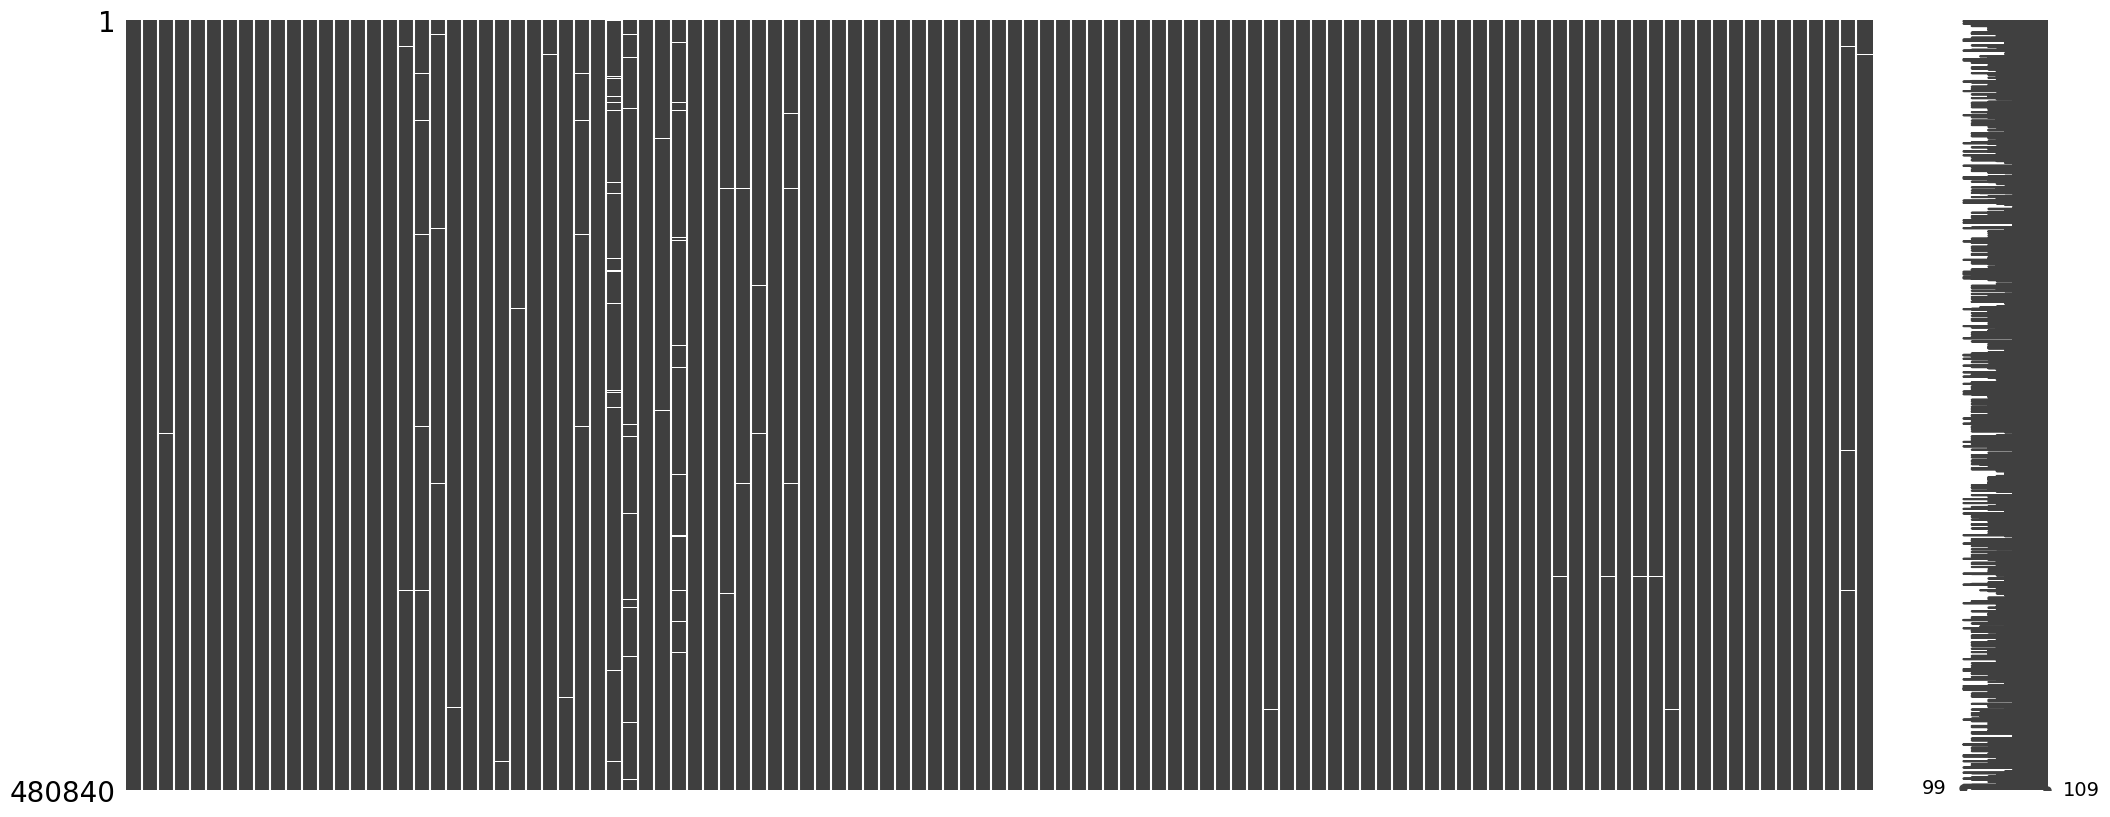

In [ ]:
# Visualize dataset before imputation
import missingno as msno

msno.matrix(to_impute)

In [ ]:
#Apply kNN imputation
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(to_impute)
knn_imputed_biomarker = pd.DataFrame(imputed_array, columns=to_impute.columns, index=to_impute.index)

In [ ]:
# Save the output (if needed, just to be safe)
knn_imputed_biomarker.insert(0, 'eid', cleaned_biomarker['eid'])
knn_imputed_biomarker.to_csv('all_knn_imputed_biomarker_nonderived.csv', index = False)

In [ ]:
%%bash
dx upload "all_knn_imputed_biomarker_nonderived.csv"

ID                                file-J503Jz0JZ8jjG3VQvKKvjv7Z
Class                             file
Project                           project-J0yb91QJZ8jZ9ppFk6zGQgGp
Folder                            /
Name                              all_knn_imputed_biomarker_nonderived.csv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Mon Dec 15 16:27:40 2025
Created by                        agarham
 via the job                      job-J5011Q8JZ8jj9bYp0Xkx7XgB
Last modified                     Mon Dec 15 16:27:43 2025
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"


In [ ]:
# Remove the eid column for subsequent steps (will be returned later)
knn_imputed_biomarker = knn_imputed_biomarker.drop(columns=['eid'])

to_impute shape:
(480840, 109)
flags shape:
(480840, 109)
knn_imputed_biomarker shape:
(480840, 109)


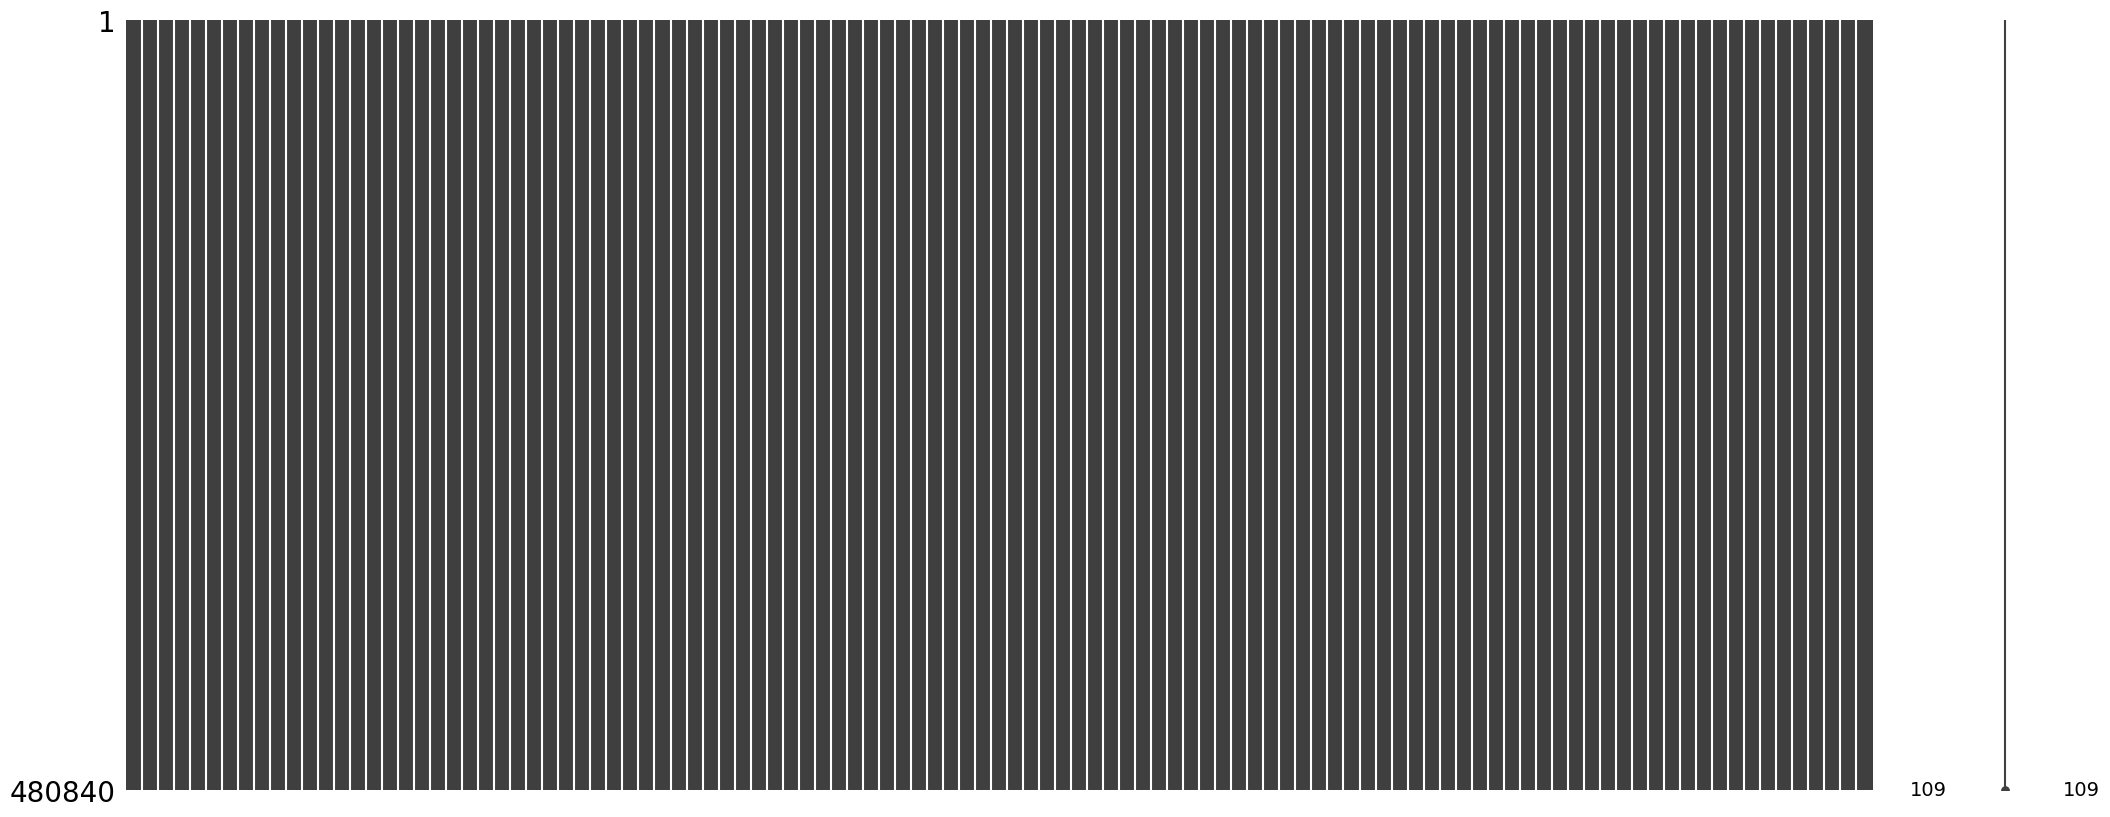

In [ ]:
# Visualize dataset after imputation
msno.matrix(knn_imputed_biomarker)

# Check shapes
print('to_impute shape:')
print(to_impute.shape)

print('flags shape:')
print(flags.shape)

print('knn_imputed_biomarker shape:')
print(knn_imputed_biomarker.shape)

In [ ]:
# # If needed for divided works
# %%bash
# dx download "all_knn_imputed_biomarker_nonderived.csv"

In [ ]:
# # If needed for divided works
# # Load the pre saved dataset
# knn_imputed_biomarker = pd.read_csv('all_knn_imputed_biomarker_nonderived.csv')

In [ ]:
# Create mask of missing values in the biomarker dataset
mask_nan = to_impute.isna()

# Create mask of NOT missing flag in the qc dataset
mask_flag = flags.notna()

# Create mask for flags NOT containing 'Below limit of quantification' (case insensitive)
mask_non_loq = ~flags.astype(str).map(
    lambda x: 'below limit of quantification' in x.lower()
)

# Count number of NaNs
all_nan_count = mask_nan.sum().sum()

# Count flagged NaNs
flagged_nan_count = (mask_nan & mask_flag).sum().sum()
pct_flagged_nan = (flagged_nan_count/all_nan_count)*100

non_flagged_nan_count = (mask_nan & ~mask_flag).sum().sum()
pct_non_flagged_nan = (non_flagged_nan_count/all_nan_count)*100

# Count LoQ flags
loq_count = (mask_nan & mask_flag & ~mask_non_loq).sum().sum()
pct_loq = (loq_count/flagged_nan_count)*100

non_loq_count = (mask_nan & mask_flag & mask_non_loq).sum().sum()
pct_non_loq = (non_loq_count/flagged_nan_count)*100

print(f'Number of NaNs: {all_nan_count}')

print(f'Number of flagged NaNs: {flagged_nan_count}')
print(f'Percentage of flagged NaNs of total NaNs: {pct_flagged_nan}')

print(f'Number of non-flagged NaNs: {non_flagged_nan_count}')
print(f'Percentage of non-flagged NaNs of total NaNs: {pct_non_flagged_nan}')

print(f'Number of LoQ flags: {loq_count}')
print(f'Percentage of LoQ flags of total flags: {pct_loq}')

print(f'Number of non-LoQ flags: {non_loq_count}')
print(f'Percentage of non-LoQ flags of total flags: {pct_non_loq}')

Number of NaNs: 55873
Number of flagged NaNs: 48382
Percentage of flagged NaNs of total NaNs: 86.59280869113883
Number of non-flagged NaNs: 7491
Percentage of non-flagged NaNs of total NaNs: 13.407191308861165
Number of LoQ flags: 1803
Percentage of LoQ flags of total flags: 3.7265925344136246
Number of non-LoQ flags: 46579
Percentage of non-LoQ flags of total flags: 96.27340746558637


knn_imputed_biomarker_final shape:
(480840, 110)
match eid on the final dataset vs the cleaned dataset:
True
number of missingness BEFORE imputation:
55873
number of missingness AFTER imputation (kNN only):
9294


<Axes: >

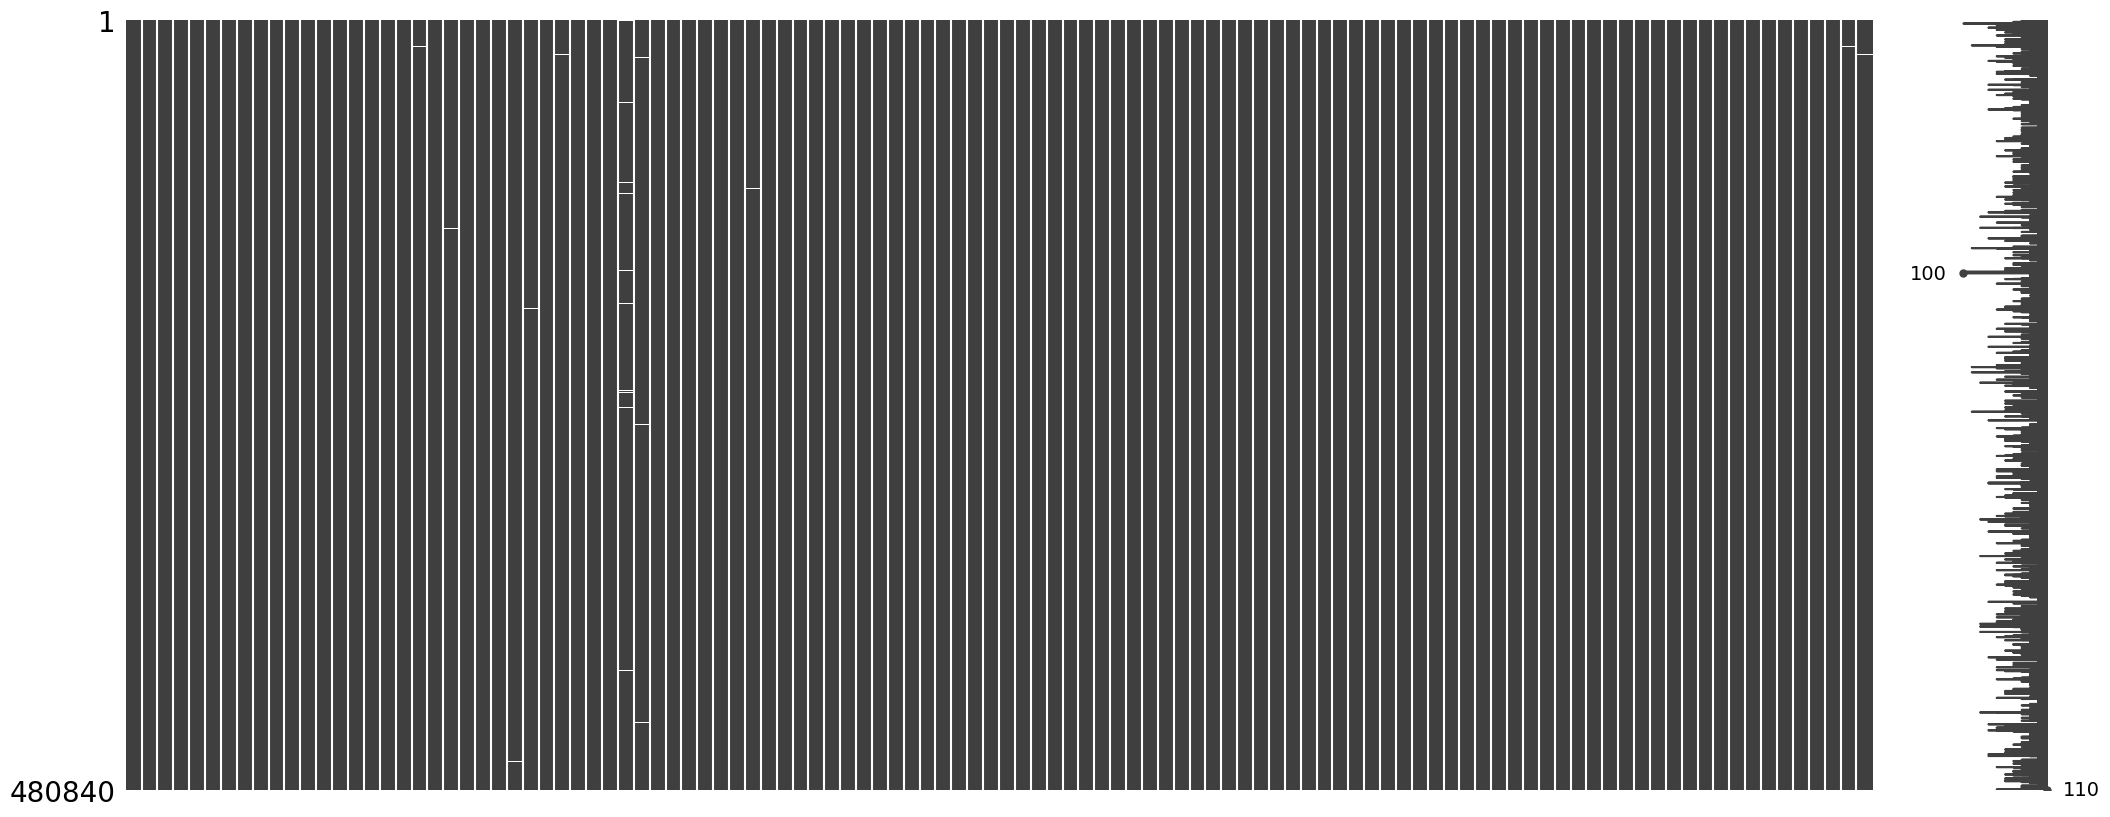

In [ ]:
# Mask for cells to impute = missing & flag not LoQ
mask_impute = mask_nan & mask_flag & mask_non_loq

# Restore original NaNs for values we didn't want to impute (those LoQ flagged and not flagged)
knn_imputed_biomarker_final = to_impute.copy()
knn_imputed_biomarker_final.values[mask_impute.values] = knn_imputed_biomarker.values[mask_impute.values]

# Add back eid column
knn_imputed_biomarker_final.insert(0, 'eid', cleaned_biomarker['eid'])

# Save the output
knn_imputed_biomarker_final.to_csv('knn_imputed_non_loq_metabolomics_nonderived.csv', index = False)

# Check results
print('knn_imputed_biomarker_final shape:')
print(knn_imputed_biomarker_final.shape)

print('match eid on the final dataset vs the cleaned dataset:')
print(set(cleaned_biomarker['eid']) == set(knn_imputed_biomarker_final['eid']))

print('number of missingness BEFORE imputation:')
print(to_impute.isna().sum().sum())

print('number of missingness AFTER imputation (kNN only):')
print(knn_imputed_biomarker_final.isna().sum().sum())

# Visualize the final dataset
msno.matrix(knn_imputed_biomarker_final)

In [ ]:
%%bash
dx upload "knn_imputed_non_loq_metabolomics_nonderived.csv"

ID                                file-J503Kq0JZ8jvq9Yq2Z1JJpfk
Class                             file
Project                           project-J0yb91QJZ8jZ9ppFk6zGQgGp
Folder                            /
Name                              knn_imputed_non_loq_metabolomics_nonderived.csv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Mon Dec 15 16:29:32 2025
Created by                        agarham
 via the job                      job-J5011Q8JZ8jj9bYp0Xkx7XgB
Last modified                     Mon Dec 15 16:29:36 2025
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"


#### 2.3.2. QRILC imputation for LoQ flagged missing values

In [ ]:
%%bash
dx download "qrilc_imputation_v2.r"

In [ ]:
# Perform QRILC imputation and recalculating derived biomarkers in R
subprocess.run(["Rscript", "qrilc_imputation_v2.r", "knn_imputed_non_loq_metabolomics_nonderived.csv"])

CompletedProcess(args=['Rscript', 'qrilc_imputation_v2.r', 'knn_imputed_non_loq_metabolomics_nonderived.csv'], returncode=0)

<Axes: >

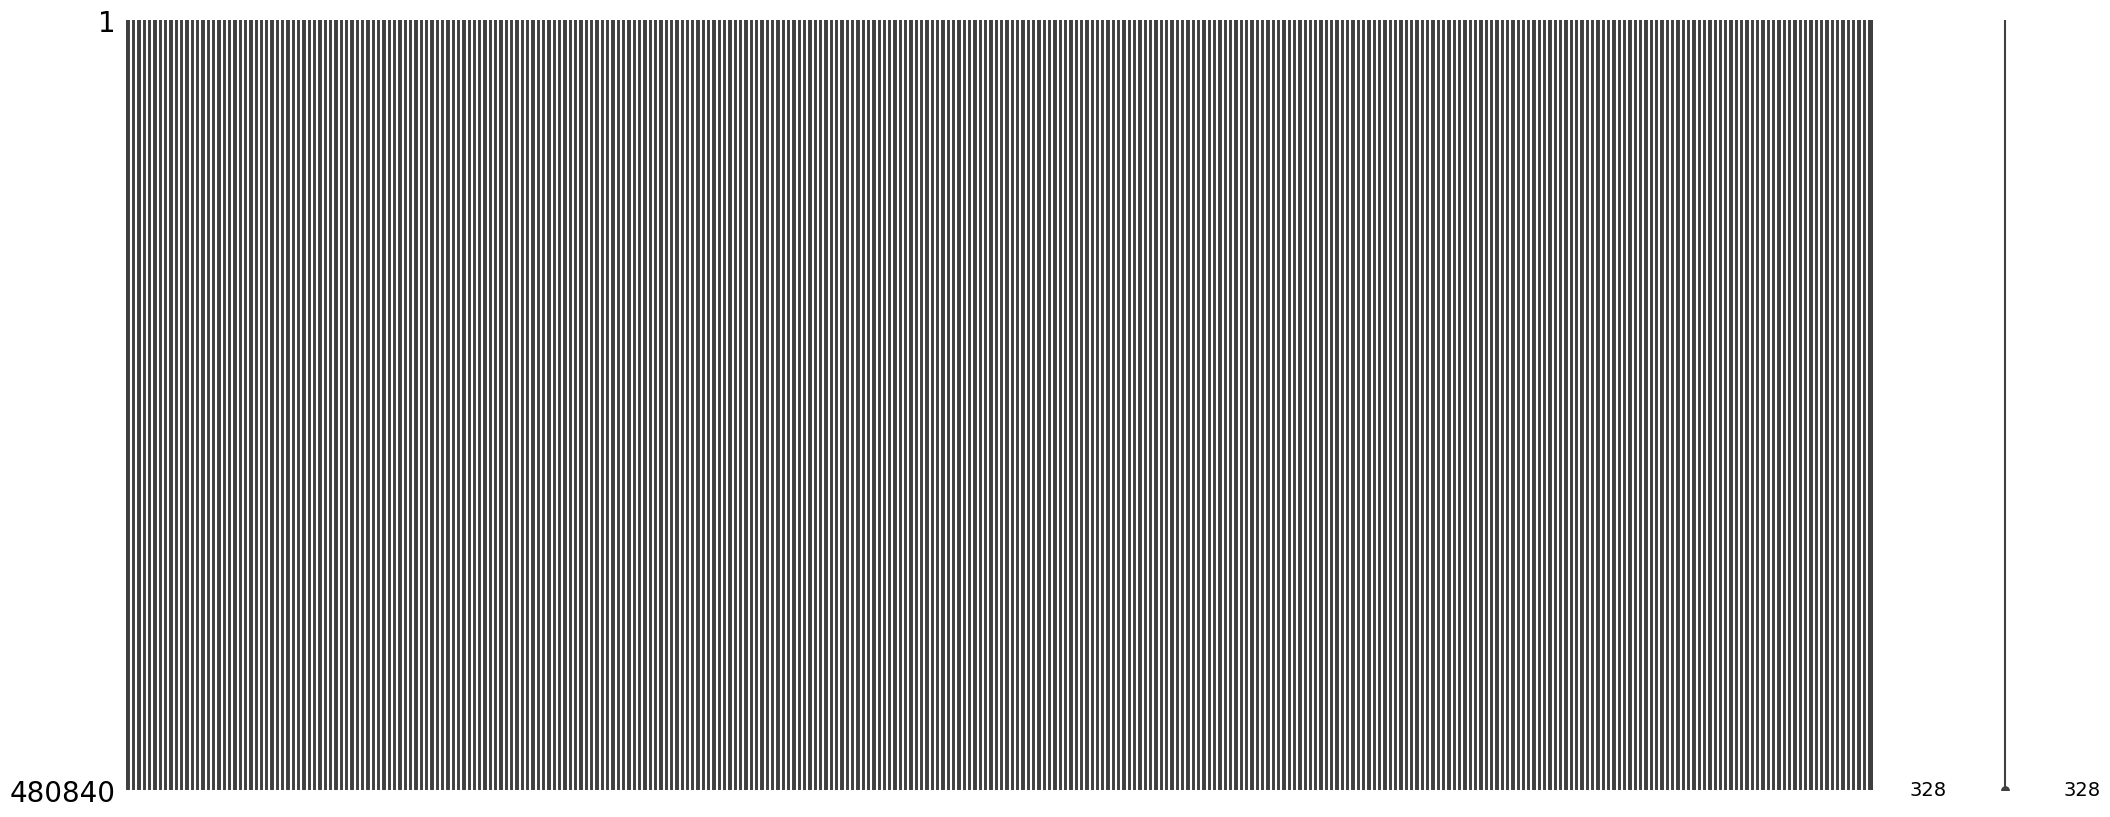

In [ ]:
# Check QRILC imputation results
qrilc_imputed_biomarker = pd.read_csv('qrilc_imputed_metabolomics_v3.csv')

msno.matrix(qrilc_imputed_biomarker)

The dataset is now recomputed for composite, ratio, and percentages (including the extended sets from ukbnmr package)

In [ ]:
%%bash
dx upload "qrilc_imputed_metabolomics_v3.csv"

ID                                file-J503Qx8JZ8jZzpZX57YKPbxX
Class                             file
Project                           project-J0yb91QJZ8jZ9ppFk6zGQgGp
Folder                            /
Name                              qrilc_imputed_metabolomics_v3.csv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Mon Dec 15 16:33:57 2025
Created by                        agarham
 via the job                      job-J5011Q8JZ8jj9bYp0Xkx7XgB
Last modified                     Mon Dec 15 16:34:05 2025
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"
